<a href="https://colab.research.google.com/github/realfolkcode/AdversarialRegularization/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and install

In [ ]:
import torch
from torch import nn
import numpy as np
import torchvision
from torchvision import transforms
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
!git clone https://github.com/realfolkcode/AdversarialRegularization.git

Cloning into 'AdversarialRegularization'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 1), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
from AdversarialRegularization.utils import set_random_seeds, get_accuracy

# Prepare data

In [ ]:
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5)])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5)])

batch_size = 256

train_set = torchvision.datasets.CIFAR100('./cifar', train=True, download=True,
                                         transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR100('./cifar', train=False, download=True,
                                        transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

print('Train size', len(train_set))
print('Test size', len(test_set))

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar/cifar-100-python.tar.gz to ./cifar
Files already downloaded and verified
Train size 50000
Test size 10000


In [ ]:
def plot_random_images(loader):
    dataiter = iter(loader)
    images, labels = dataiter.next()

    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.figure(figsize=(16, 2))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
    
    imshow(torchvision.utils.make_grid(images[:8]))

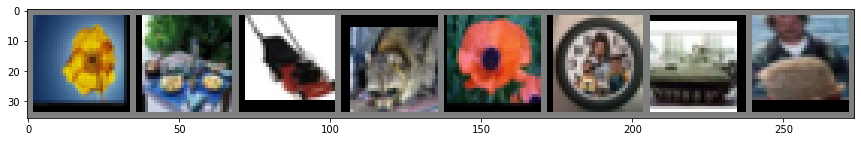

In [ ]:
plot_random_images(train_loader)

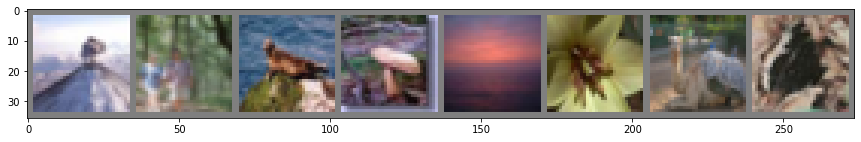

In [ ]:
plot_random_images(test_loader)

# Train classifier

In [ ]:
def epoch_train(loader, clf, criterion, opt):
    clf.train()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = clf(data)
        loss = criterion(output, target)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
    clf.eval()
    train_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = clf(data)
            train_loss += criterion(output, target).item()
    train_acc = get_accuracy(clf, loader, device)
    train_loss /= len(loader.dataset)
    return train_loss, train_acc


def epoch_test(loader, clf, criterion):
    clf.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = clf(data)
            test_loss += criterion(output, target).item()
    test_acc = get_accuracy(clf, loader, device)
    test_loss /= len(loader.dataset)
    return test_loss, test_acc


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
RANDOM_SEED = 0

set_random_seeds(seed_value=RANDOM_SEED, device=device)

torch.cuda.set_device(0)
clf_cnn = CNN(num_classes=100).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_cnn.parameters()]))
    
# Check that the output size of the network is BATCH_SIZE x NUM_CLASSES
X = next(iter(train_loader))[0].cuda()
with torch.no_grad():
    clf_X = clf_cnn(X)
    assert len(clf_X) == len(X)
    assert clf_X.shape[1] == 100

Number of weights: 945572


In [ ]:
opt = torch.optim.Adam(clf_cnn.parameters(), weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train(train_loader, test_loader, clf_cnn, criterion, opt, n_epochs=100)

  1%|          | 1/100 [01:08<1:52:21, 68.09s/it]

[Epoch 1] train loss: 0.013; train acc: 0.17; test loss: 0.014; test acc: 0.18


  2%|▏         | 2/100 [02:16<1:51:35, 68.32s/it]

[Epoch 2] train loss: 0.012; train acc: 0.25; test loss: 0.012; test acc: 0.26


  3%|▎         | 3/100 [03:24<1:50:07, 68.12s/it]

[Epoch 3] train loss: 0.011; train acc: 0.31; test loss: 0.011; test acc: 0.32


  4%|▍         | 4/100 [04:32<1:48:56, 68.09s/it]

[Epoch 4] train loss: 0.010; train acc: 0.32; test loss: 0.011; test acc: 0.33


  5%|▌         | 5/100 [05:40<1:48:00, 68.22s/it]

[Epoch 5] train loss: 0.009; train acc: 0.37; test loss: 0.010; test acc: 0.37


  6%|▌         | 6/100 [06:49<1:47:01, 68.31s/it]

[Epoch 6] train loss: 0.009; train acc: 0.39; test loss: 0.010; test acc: 0.38


  7%|▋         | 7/100 [07:57<1:45:51, 68.30s/it]

[Epoch 7] train loss: 0.009; train acc: 0.42; test loss: 0.009; test acc: 0.41


  8%|▊         | 8/100 [09:06<1:44:53, 68.40s/it]

[Epoch 8] train loss: 0.008; train acc: 0.45; test loss: 0.009; test acc: 0.43


  9%|▉         | 9/100 [10:14<1:43:35, 68.30s/it]

[Epoch 9] train loss: 0.008; train acc: 0.47; test loss: 0.008; test acc: 0.46


 10%|█         | 10/100 [11:22<1:42:23, 68.26s/it]

[Epoch 10] train loss: 0.008; train acc: 0.48; test loss: 0.008; test acc: 0.45


 11%|█         | 11/100 [12:30<1:40:58, 68.08s/it]

[Epoch 11] train loss: 0.008; train acc: 0.48; test loss: 0.008; test acc: 0.45


 12%|█▏        | 12/100 [13:37<1:39:37, 67.93s/it]

[Epoch 12] train loss: 0.007; train acc: 0.49; test loss: 0.009; test acc: 0.45


 13%|█▎        | 13/100 [14:45<1:38:16, 67.77s/it]

[Epoch 13] train loss: 0.007; train acc: 0.51; test loss: 0.008; test acc: 0.47


 14%|█▍        | 14/100 [15:52<1:36:45, 67.50s/it]

[Epoch 14] train loss: 0.007; train acc: 0.52; test loss: 0.008; test acc: 0.48


 15%|█▌        | 15/100 [16:59<1:35:22, 67.33s/it]

[Epoch 15] train loss: 0.007; train acc: 0.54; test loss: 0.008; test acc: 0.49


 16%|█▌        | 16/100 [18:06<1:34:12, 67.30s/it]

[Epoch 16] train loss: 0.006; train acc: 0.55; test loss: 0.008; test acc: 0.49


 17%|█▋        | 17/100 [19:13<1:32:54, 67.17s/it]

[Epoch 17] train loss: 0.006; train acc: 0.54; test loss: 0.008; test acc: 0.49


 18%|█▊        | 18/100 [20:20<1:31:45, 67.14s/it]

[Epoch 18] train loss: 0.006; train acc: 0.55; test loss: 0.008; test acc: 0.50


 19%|█▉        | 19/100 [21:26<1:30:29, 67.03s/it]

[Epoch 19] train loss: 0.006; train acc: 0.56; test loss: 0.008; test acc: 0.51


 20%|██        | 20/100 [22:33<1:29:16, 66.95s/it]

[Epoch 20] train loss: 0.006; train acc: 0.58; test loss: 0.008; test acc: 0.50


 21%|██        | 21/100 [23:40<1:28:06, 66.91s/it]

[Epoch 21] train loss: 0.006; train acc: 0.57; test loss: 0.008; test acc: 0.50


 22%|██▏       | 22/100 [24:46<1:26:47, 66.76s/it]

[Epoch 22] train loss: 0.006; train acc: 0.59; test loss: 0.008; test acc: 0.51


 23%|██▎       | 23/100 [25:53<1:25:32, 66.65s/it]

[Epoch 23] train loss: 0.006; train acc: 0.59; test loss: 0.008; test acc: 0.51


 24%|██▍       | 24/100 [26:59<1:24:12, 66.47s/it]

[Epoch 24] train loss: 0.006; train acc: 0.60; test loss: 0.007; test acc: 0.51


 25%|██▌       | 25/100 [28:05<1:22:55, 66.34s/it]

[Epoch 25] train loss: 0.005; train acc: 0.61; test loss: 0.007; test acc: 0.52


 26%|██▌       | 26/100 [29:11<1:21:41, 66.24s/it]

[Epoch 26] train loss: 0.005; train acc: 0.62; test loss: 0.007; test acc: 0.53


 27%|██▋       | 27/100 [30:17<1:20:25, 66.11s/it]

[Epoch 27] train loss: 0.005; train acc: 0.62; test loss: 0.007; test acc: 0.53


 28%|██▊       | 28/100 [31:23<1:19:14, 66.03s/it]

[Epoch 28] train loss: 0.005; train acc: 0.63; test loss: 0.007; test acc: 0.52


 29%|██▉       | 29/100 [32:28<1:18:02, 65.95s/it]

[Epoch 29] train loss: 0.005; train acc: 0.64; test loss: 0.007; test acc: 0.53


 30%|███       | 30/100 [33:34<1:16:47, 65.82s/it]

[Epoch 30] train loss: 0.005; train acc: 0.64; test loss: 0.007; test acc: 0.53


 31%|███       | 31/100 [34:40<1:15:40, 65.81s/it]

[Epoch 31] train loss: 0.005; train acc: 0.64; test loss: 0.007; test acc: 0.53


 32%|███▏      | 32/100 [35:45<1:14:21, 65.61s/it]

[Epoch 32] train loss: 0.005; train acc: 0.66; test loss: 0.007; test acc: 0.54


 33%|███▎      | 33/100 [36:50<1:13:09, 65.51s/it]

[Epoch 33] train loss: 0.005; train acc: 0.65; test loss: 0.007; test acc: 0.54


 34%|███▍      | 34/100 [37:56<1:12:03, 65.51s/it]

[Epoch 34] train loss: 0.005; train acc: 0.64; test loss: 0.007; test acc: 0.53


 35%|███▌      | 35/100 [39:01<1:10:53, 65.43s/it]

[Epoch 35] train loss: 0.005; train acc: 0.66; test loss: 0.007; test acc: 0.53


 36%|███▌      | 36/100 [40:06<1:09:44, 65.39s/it]

[Epoch 36] train loss: 0.004; train acc: 0.67; test loss: 0.007; test acc: 0.54


 37%|███▋      | 37/100 [41:12<1:08:41, 65.41s/it]

[Epoch 37] train loss: 0.005; train acc: 0.66; test loss: 0.007; test acc: 0.53


 38%|███▊      | 38/100 [42:17<1:07:35, 65.40s/it]

[Epoch 38] train loss: 0.005; train acc: 0.66; test loss: 0.007; test acc: 0.53


 39%|███▉      | 39/100 [43:22<1:06:26, 65.36s/it]

[Epoch 39] train loss: 0.004; train acc: 0.67; test loss: 0.007; test acc: 0.54


 40%|████      | 40/100 [44:27<1:05:12, 65.21s/it]

[Epoch 40] train loss: 0.004; train acc: 0.68; test loss: 0.008; test acc: 0.54


 41%|████      | 41/100 [45:32<1:04:00, 65.09s/it]

[Epoch 41] train loss: 0.004; train acc: 0.68; test loss: 0.007; test acc: 0.54


 42%|████▏     | 42/100 [46:37<1:02:55, 65.09s/it]

[Epoch 42] train loss: 0.004; train acc: 0.69; test loss: 0.007; test acc: 0.54


 43%|████▎     | 43/100 [47:42<1:01:52, 65.12s/it]

[Epoch 43] train loss: 0.004; train acc: 0.70; test loss: 0.007; test acc: 0.55


 44%|████▍     | 44/100 [48:47<1:00:47, 65.14s/it]

[Epoch 44] train loss: 0.004; train acc: 0.68; test loss: 0.007; test acc: 0.54


 45%|████▌     | 45/100 [49:53<59:44, 65.17s/it]  

[Epoch 45] train loss: 0.004; train acc: 0.68; test loss: 0.008; test acc: 0.54


 46%|████▌     | 46/100 [50:58<58:40, 65.20s/it]

[Epoch 46] train loss: 0.004; train acc: 0.70; test loss: 0.007; test acc: 0.55


 47%|████▋     | 47/100 [52:03<57:36, 65.21s/it]

[Epoch 47] train loss: 0.004; train acc: 0.69; test loss: 0.008; test acc: 0.54


 48%|████▊     | 48/100 [53:08<56:27, 65.15s/it]

[Epoch 48] train loss: 0.004; train acc: 0.69; test loss: 0.008; test acc: 0.54


 49%|████▉     | 49/100 [54:13<55:24, 65.18s/it]

[Epoch 49] train loss: 0.004; train acc: 0.71; test loss: 0.007; test acc: 0.54


 50%|█████     | 50/100 [55:19<54:22, 65.25s/it]

[Epoch 50] train loss: 0.004; train acc: 0.71; test loss: 0.007; test acc: 0.54


 51%|█████     | 51/100 [56:24<53:18, 65.28s/it]

[Epoch 51] train loss: 0.004; train acc: 0.72; test loss: 0.007; test acc: 0.55


 52%|█████▏    | 52/100 [57:30<52:15, 65.33s/it]

[Epoch 52] train loss: 0.004; train acc: 0.72; test loss: 0.007; test acc: 0.55


 53%|█████▎    | 53/100 [58:35<51:08, 65.28s/it]

[Epoch 53] train loss: 0.004; train acc: 0.71; test loss: 0.008; test acc: 0.54


 54%|█████▍    | 54/100 [59:40<50:01, 65.24s/it]

[Epoch 54] train loss: 0.004; train acc: 0.73; test loss: 0.007; test acc: 0.55


 55%|█████▌    | 55/100 [1:00:45<48:55, 65.23s/it]

[Epoch 55] train loss: 0.004; train acc: 0.72; test loss: 0.007; test acc: 0.55


 56%|█████▌    | 56/100 [1:01:51<47:55, 65.35s/it]

[Epoch 56] train loss: 0.004; train acc: 0.72; test loss: 0.008; test acc: 0.54


 57%|█████▋    | 57/100 [1:02:56<46:49, 65.34s/it]

[Epoch 57] train loss: 0.004; train acc: 0.73; test loss: 0.007; test acc: 0.55


 58%|█████▊    | 58/100 [1:04:02<45:48, 65.44s/it]

[Epoch 58] train loss: 0.004; train acc: 0.72; test loss: 0.008; test acc: 0.54


 59%|█████▉    | 59/100 [1:05:07<44:41, 65.40s/it]

[Epoch 59] train loss: 0.003; train acc: 0.74; test loss: 0.007; test acc: 0.56


 60%|██████    | 60/100 [1:06:13<43:44, 65.61s/it]

[Epoch 60] train loss: 0.004; train acc: 0.73; test loss: 0.007; test acc: 0.55


 61%|██████    | 61/100 [1:07:19<42:43, 65.73s/it]

[Epoch 61] train loss: 0.004; train acc: 0.73; test loss: 0.008; test acc: 0.54


 62%|██████▏   | 62/100 [1:08:25<41:34, 65.65s/it]

[Epoch 62] train loss: 0.003; train acc: 0.74; test loss: 0.008; test acc: 0.55


 63%|██████▎   | 63/100 [1:09:30<40:29, 65.65s/it]

[Epoch 63] train loss: 0.003; train acc: 0.74; test loss: 0.008; test acc: 0.55


 64%|██████▍   | 64/100 [1:10:36<39:21, 65.60s/it]

[Epoch 64] train loss: 0.003; train acc: 0.74; test loss: 0.008; test acc: 0.55


 65%|██████▌   | 65/100 [1:11:41<38:17, 65.64s/it]

[Epoch 65] train loss: 0.003; train acc: 0.75; test loss: 0.008; test acc: 0.55


 66%|██████▌   | 66/100 [1:12:47<37:07, 65.52s/it]

[Epoch 66] train loss: 0.003; train acc: 0.74; test loss: 0.008; test acc: 0.54


 67%|██████▋   | 67/100 [1:13:52<36:00, 65.47s/it]

[Epoch 67] train loss: 0.003; train acc: 0.75; test loss: 0.008; test acc: 0.56


 68%|██████▊   | 68/100 [1:14:58<34:59, 65.59s/it]

[Epoch 68] train loss: 0.003; train acc: 0.75; test loss: 0.008; test acc: 0.55


 69%|██████▉   | 69/100 [1:16:04<33:53, 65.59s/it]

[Epoch 69] train loss: 0.003; train acc: 0.76; test loss: 0.008; test acc: 0.56


 70%|███████   | 70/100 [1:17:09<32:47, 65.60s/it]

[Epoch 70] train loss: 0.003; train acc: 0.74; test loss: 0.008; test acc: 0.54


 71%|███████   | 71/100 [1:18:15<31:43, 65.62s/it]

[Epoch 71] train loss: 0.003; train acc: 0.75; test loss: 0.008; test acc: 0.55


 72%|███████▏  | 72/100 [1:19:20<30:35, 65.54s/it]

[Epoch 72] train loss: 0.003; train acc: 0.76; test loss: 0.008; test acc: 0.56


 73%|███████▎  | 73/100 [1:20:26<29:30, 65.56s/it]

[Epoch 73] train loss: 0.003; train acc: 0.76; test loss: 0.008; test acc: 0.55


 74%|███████▍  | 74/100 [1:21:31<28:25, 65.59s/it]

[Epoch 74] train loss: 0.003; train acc: 0.76; test loss: 0.008; test acc: 0.55


 75%|███████▌  | 75/100 [1:22:37<27:18, 65.52s/it]

[Epoch 75] train loss: 0.003; train acc: 0.77; test loss: 0.008; test acc: 0.55


 76%|███████▌  | 76/100 [1:23:42<26:11, 65.50s/it]

[Epoch 76] train loss: 0.003; train acc: 0.77; test loss: 0.008; test acc: 0.55


 77%|███████▋  | 77/100 [1:24:48<25:06, 65.48s/it]

[Epoch 77] train loss: 0.003; train acc: 0.76; test loss: 0.008; test acc: 0.55


 78%|███████▊  | 78/100 [1:25:53<24:01, 65.54s/it]

[Epoch 78] train loss: 0.003; train acc: 0.75; test loss: 0.008; test acc: 0.54


 79%|███████▉  | 79/100 [1:26:59<22:55, 65.49s/it]

[Epoch 79] train loss: 0.003; train acc: 0.76; test loss: 0.008; test acc: 0.55


 80%|████████  | 80/100 [1:28:04<21:48, 65.41s/it]

[Epoch 80] train loss: 0.003; train acc: 0.76; test loss: 0.008; test acc: 0.54


 81%|████████  | 81/100 [1:29:10<20:44, 65.49s/it]

[Epoch 81] train loss: 0.003; train acc: 0.78; test loss: 0.008; test acc: 0.55


 82%|████████▏ | 82/100 [1:30:15<19:38, 65.50s/it]

[Epoch 82] train loss: 0.003; train acc: 0.75; test loss: 0.008; test acc: 0.54


 83%|████████▎ | 83/100 [1:31:20<18:32, 65.44s/it]

[Epoch 83] train loss: 0.003; train acc: 0.77; test loss: 0.008; test acc: 0.54


 84%|████████▍ | 84/100 [1:32:26<17:26, 65.38s/it]

[Epoch 84] train loss: 0.003; train acc: 0.77; test loss: 0.008; test acc: 0.55


 85%|████████▌ | 85/100 [1:33:31<16:20, 65.40s/it]

[Epoch 85] train loss: 0.003; train acc: 0.78; test loss: 0.008; test acc: 0.56


 86%|████████▌ | 86/100 [1:34:36<15:15, 65.37s/it]

[Epoch 86] train loss: 0.003; train acc: 0.77; test loss: 0.008; test acc: 0.55


 87%|████████▋ | 87/100 [1:35:42<14:10, 65.41s/it]

[Epoch 87] train loss: 0.003; train acc: 0.79; test loss: 0.008; test acc: 0.56


 88%|████████▊ | 88/100 [1:36:48<13:06, 65.51s/it]

[Epoch 88] train loss: 0.003; train acc: 0.77; test loss: 0.008; test acc: 0.54


 89%|████████▉ | 89/100 [1:37:54<12:02, 65.66s/it]

[Epoch 89] train loss: 0.003; train acc: 0.78; test loss: 0.008; test acc: 0.55


 90%|█████████ | 90/100 [1:38:59<10:56, 65.69s/it]

[Epoch 90] train loss: 0.003; train acc: 0.77; test loss: 0.008; test acc: 0.55


 91%|█████████ | 91/100 [1:40:05<09:50, 65.66s/it]

[Epoch 91] train loss: 0.003; train acc: 0.78; test loss: 0.008; test acc: 0.55


 92%|█████████▏| 92/100 [1:41:10<08:44, 65.53s/it]

[Epoch 92] train loss: 0.003; train acc: 0.78; test loss: 0.008; test acc: 0.55


 93%|█████████▎| 93/100 [1:42:16<07:38, 65.55s/it]

[Epoch 93] train loss: 0.003; train acc: 0.79; test loss: 0.008; test acc: 0.55


 94%|█████████▍| 94/100 [1:43:21<06:32, 65.48s/it]

[Epoch 94] train loss: 0.003; train acc: 0.78; test loss: 0.008; test acc: 0.56


 95%|█████████▌| 95/100 [1:44:27<05:27, 65.49s/it]

[Epoch 95] train loss: 0.003; train acc: 0.78; test loss: 0.008; test acc: 0.56


 96%|█████████▌| 96/100 [1:45:32<04:21, 65.49s/it]

[Epoch 96] train loss: 0.003; train acc: 0.79; test loss: 0.008; test acc: 0.55


 97%|█████████▋| 97/100 [1:46:38<03:16, 65.53s/it]

[Epoch 97] train loss: 0.003; train acc: 0.79; test loss: 0.008; test acc: 0.55


 98%|█████████▊| 98/100 [1:47:43<02:11, 65.54s/it]

[Epoch 98] train loss: 0.003; train acc: 0.78; test loss: 0.008; test acc: 0.56


 99%|█████████▉| 99/100 [1:48:49<01:05, 65.50s/it]

[Epoch 99] train loss: 0.003; train acc: 0.79; test loss: 0.008; test acc: 0.55


100%|██████████| 100/100 [1:49:54<00:00, 65.95s/it]

[Epoch 100] train loss: 0.003; train acc: 0.79; test loss: 0.008; test acc: 0.55


In [ ]:
torch.save(clf_cnn.state_dict(), 'model1_seed0.pt')